# The Hipster Effect: An IPython Interactive Exploration

*This notebook originally appeared as a [post](http://jakevdp.github.io/blog/2014/11/11/the-hipster-effect-interactive/) on the blog [Pythonic Perambulations](http://jakevdp.github.io). The content is BSD licensed.*

<!-- PELICAN_BEGIN_SUMMARY -->

This week I started seeing references all over the internet to [this paper](http://arxiv.org/abs/1410.8001): *The Hipster Effect: When Anticonformists All Look The Same*. It essentially describes a simple mathematical model which models conformity and non-conformity among a mutually interacting population, and finds some interesting results: namely, **conformity among a population of self-conscious non-conformists is similar to a phase transition in a time-delayed thermodynamic system**. In other words, with enough hipsters around responding to delayed fashion trends, a plethora of facial hair and fixed gear bikes is a natural result.

Also naturally, upon reading the paper I wanted to try to reproduce the work. The paper solves the problem analytically for a continuous system and shows the precise values of certain phase transitions within the long-term limit of the postulated system. Though such theoretical derivations are useful, I often find it more intuitive to simulate systems like this in a more approximate manner to gain hands-on understanding. By the end of this notebook, we'll be using IPython's incredible [interactive widgets](http://nbviewer.ipython.org/github/ipython/ipython/blob/master/examples/Interactive%20Widgets/Index.ipynb) to explore how the inputs to this model affect the results.

<!-- PELICAN_END_SUMMARY -->

## Mathematically Modeling Hipsters

We'll start by defining the problem, and going through the notation suggested in the paper. We'll consider a group of $N$ people, and define the following quantities:

- $\epsilon_i$ : this value is either $+1$ or $-1$. $+1$ means person $i$ is a hipster, while $-1$ means they're a conformist.
- $s_i(t)$ : this is also either $+1$ or $-1$. This indicates person $i$'s choice of style at time $t$. For example, $+1$ might indicated a bushy beard, while $-1$ indicates clean-shaven.
- $J_{ij}$ : The influence matrix. This is a value greater than zero which indicates how much person $j$ influences person $i$.
- $\tau_{ij}$ : The delay matrix. This is an integer telling us the length of delay for the style of person $j$ to affect the style of person $i$.

The idea of the model is this: on any given day, person $i$ looks at the world around him or her, and sees some previous day's version of everyone else. This information is $s_j(t - \tau_{ij})$.

The amount that person $j$ influences person $i$ is given by the influence matrix, $J_{ij}$, and after putting all the information together, we see that person $i$'s mean impression of the world's style is

$$
m_i(t) = \frac{1}{N} \sum_j J_{ij} \cdot s_j(t - \tau_{ij})
$$

Given the problem setup, we can quickly check whether this impression matches their own current style:

- if $m_i(t) \cdot s_i(t) > 0$, then person $i$ matches those around them
- if $m_i(t) \cdot s_i(t) < 0$, then person $i$ looks different than those around them

A hipster who notices that their style matches that of the world around them will risk giving up all their hipster cred if they don't change quickly; a conformist will have the opposite reaction. Because $\epsilon_i$ = $+1$ for a hipster and $-1$ for a conformist, we can encode this observation in a single value which tells us what which way the person will lean that day:

$$
x_i(t) = -\epsilon_i m_i(t) s_i(t)
$$

Simple! If $x_i(t) > 0$, then person $i$ will more likely switch their style that day, and if $x_i(t) < 0$, person $i$ will more likely maintain the same style as the previous day. So we have a formula for how to update each person's style based on their preferences, their influences, and the world around them.

But the world is a noisy place. Each person might have other things going on that day, so instead of using this value directly, we can turn it in to a probabilistic statement.  Consider the function

$$
\phi(x;\beta) = \frac{1 + \tanh(\beta \cdot x)}{2}
$$

We can plot this function quickly:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Use seaborn styles for nice-looking plots
import seaborn; seaborn.set()

ImportError: No module named seaborn

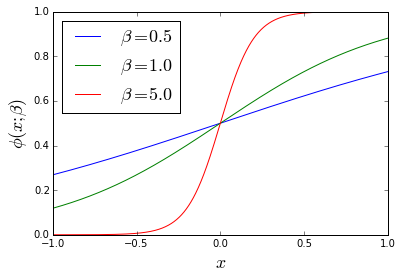

In [2]:
x = np.linspace(-1, 1, 1000)
for beta in [0.5, 1, 5]:
    plt.plot(x, 0.5 * (1 + np.tanh(beta * x)),
             label=r'$\beta = {0:.1f}$'.format(beta))
plt.legend(loc='upper left', fontsize=18)
plt.xlabel('$x$', size=18); plt.ylabel(r'$\phi(x;\beta)$', size=18);

This gives us a nice way to move from our preference $x_i$ to a probability of switching styles. Here $\beta$ is inversely related to noise. For large $\beta$, the noise is small and we basically map $x > 0$ to a 100% probability of switching, and $x<0$ to a 0% probability of switching. As $\beta$ gets smaller, the probabilities get less and less distinct.

## The Code

Let's see this model in action. We'll start by defining a class which implements everything we've gone through above:

In [3]:
class HipsterStep(object):
    """Class to implement hipster evolution
    
    Parameters
    ----------
    initial_style : length-N array
        values > 0 indicate one style, while values <= 0 indicate the other.
    is_hipster : length-N array
        True or False, indicating whether each person is a hipster
    influence_matrix : N x N array
        Array of non-negative values. influence_matrix[i, j] indicates
        how much influence person j has on person i
    delay_matrix : N x N array
        Array of positive integers. delay_matrix[i, j] indicates the
        number of days delay between person j's influence on person i.
    """
    def __init__(self, initial_style, is_hipster,
                 influence_matrix, delay_matrix,
                 beta=1, rseed=None):
        self.initial_style = initial_style
        self.is_hipster = is_hipster
        self.influence_matrix = influence_matrix
        self.delay_matrix = delay_matrix
        
        self.rng = np.random.RandomState(rseed)
        self.beta = beta
        
        # make s array consisting of -1 and 1
        self.s = -1 + 2 * (np.atleast_2d(initial_style) > 0)
        N = self.s.shape[1]
        
        # make eps array consisting of -1 and 1
        self.eps = -1 + 2 * (np.asarray(is_hipster) > 0)
        
        # create influence_matrix and delay_matrix
        self.J = np.asarray(influence_matrix, dtype=float)
        self.tau = np.asarray(delay_matrix, dtype=int)
        
        # validate all the inputs
        assert self.s.ndim == 2
        assert self.s.shape[1] == N
        assert self.eps.shape == (N,)
        assert self.J.shape == (N, N)
        assert np.all(self.J >= 0)
        assert np.all(self.tau > 0)

    @staticmethod
    def phi(x, beta):
        return 0.5 * (1 + np.tanh(beta * x))
            
    def step_once(self):
        N = self.s.shape[1]
        
        # iref[i, j] gives the index for the j^th individual's
        # time-delayed influence on the i^th individual
        iref = np.maximum(0, self.s.shape[0] - self.tau)
        
        # sref[i, j] gives the previous state of the j^th individual
        # which affects the current state of the i^th individual
        sref = self.s[iref, np.arange(N)]

        # m[i] is the mean of weighted influences of other individuals
        m = (self.J * sref).sum(1) / self.J.sum(1)
        
        # From m, we use the sigmoid function to compute a transition probability
        transition_prob = self.phi(-self.eps * m * self.s[-1], beta=self.beta)
        
        # Now choose steps stochastically based on this probability
        new_s = np.where(transition_prob > self.rng.rand(N), -1, 1) * self.s[-1]
        
        # Add this to the results, and return
        self.s = np.vstack([self.s, new_s])
        return self.s
    
    def step(self, N):
        for i in range(N):
            self.step_once()
        return self.s
    
    def trend(self, hipster=True, return_std=True):
        if hipster:
            subgroup = self.s[:, self.eps > 0]
        else:
            subgroup = self.s[:, self.eps < 0]
            
        return subgroup.mean(1), subgroup.std(1)

Now we'll create a function which plots the trend for a certain number of time steps:

In [4]:
def plot_results(Npeople=500, Nsteps=200,
                 hipster_frac=0.8, initial_state_frac=0.5,
                 delay=20, log10_beta=0.5, rseed=42):
    rng = np.random.RandomState(rseed)
    
    initial_state = (rng.rand(1, Npeople) > initial_state_frac)
    is_hipster = (rng.rand(Npeople) > hipster_frac)

    influence_matrix = abs(rng.randn(Npeople, Npeople))
    influence_matrix.flat[::Npeople + 1] = 0
    
    delay_matrix = 1 + rng.poisson(delay, size=(Npeople, Npeople))

    h = HipsterStep(initial_state, is_hipster,
                    influence_matrix, delay_matrix=delay_matrix,
                    beta=10 ** log10_beta, rseed=rseed)
    h.step(Nsteps)
    
    def beard_formatter(y, loc):
        if y == 1:
            return 'bushy-\nbeard'
        elif y == -1:
            return 'clean-\nshaven'
        else:
            return ''
        
    t = np.arange(Nsteps + 1)

    fig, ax = plt.subplots(2, sharex=True, figsize=(8, 6))
    ax[0].imshow(h.s.T, cmap='binary', interpolation='nearest')
    ax[0].set_ylabel('individual')
    ax[0].axis('tight')
    ax[0].grid(False)
    
    mu, std = h.trend(True)
    ax[1].plot(t, mu, c='red', label='hipster')
    ax[1].fill_between(t, mu - std, mu + std, color='red', alpha=0.2)
    
    mu, std = h.trend(False)
    ax[1].plot(t, mu, c='blue', label='conformist')
    ax[1].fill_between(t, mu - std, mu + std, color='blue', alpha=0.2)
    
    ax[1].set_xlabel('time')
    ax[1].set_ylabel('Trend')
    ax[1].legend(loc='best')
    ax[1].set_ylim(-1.1, 1.1);
    ax[1].set_xlim(0, Nsteps)
    ax[1].yaxis.set_major_formatter(plt.FuncFormatter(beard_formatter))

## Exploring the Result

With this code in place, we can now explore the result. We'll start by seeing what happens when just 10% of the population is made up of non-conformist hipsters:

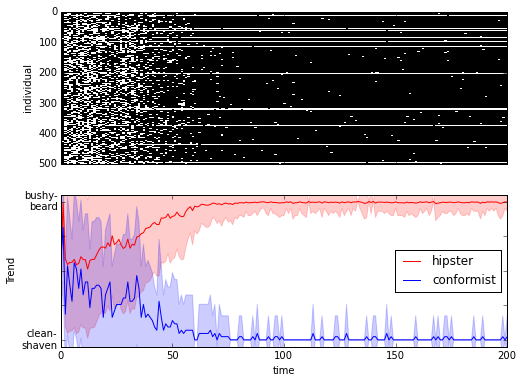

In [5]:
plot_results(hipster_frac=0.1)

Let's describe this plot briefly: the top panel has 500 rows and 200 columns: each row represents an individual person, and the color (white or black) along the row represents the style of that person at that time.

In the bottom panel, we see the mean and standard deviation of the styles of all hipsters (red) and all conformists (blue).

This plot shows something relatively unsurprising: when there are only a few hipsters in the population, we quickly reach an equilibrium where hipsters all have one style (a bushy beard) while the norm-core conformists have the opposite (clean shaven faces).

Let's see what happens if there are more hipsters in the population:

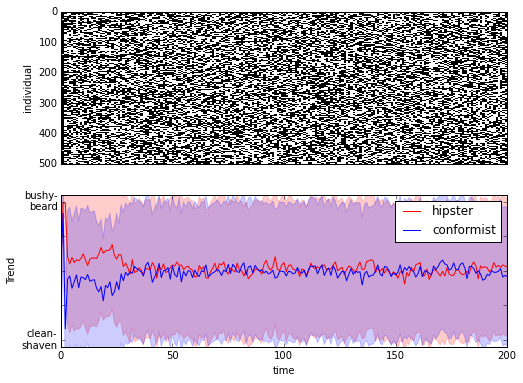

In [6]:
plot_results(hipster_frac=0.5)

With half the population made up of hipsters, the trend washes out. There is so much noise and confusion about styles, that both the hipsters and the conformists have a wide range of styles at any given time.

Now let's see what happens when we have even more hipsters:

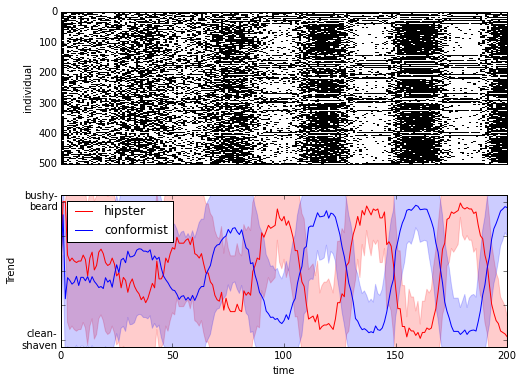

In [7]:
plot_results(hipster_frac=0.8)

Now this is getting interesting! With a population dominated by hipsters, we end up approaching steady cycles in trends. The hipsters start trying to distance themselves from the "normal" style, and then the normal style moves to catch up with them. The hipsters then swing the other way, and the process repeats. This is an example of the "phase transition" that the author of the original paper talked about in analogy to thermodynamic systems: above certain critical values of the model parameters, a qualitatively new type of behavior appears out of the noise. This oscillation can be thought of as a rough and simplistic mathematical model for recurrent cycles of cultural and fashion trends that anyone over a couple decades old has probably noticed over time.

But let's explore this even more.

## Fully Interactive

One of the nice pieces of the IPython notebook is the ability to quickly create interactive visualizations. Unfortunately this only works when you're viewing the notebook live (i.e. a static HTML view on a blog post won't give you any interaction). If you're reading this on my blog or on nbviewer, then you can [download the notebook](http://jakevdp.github.io/downloads/notebooks/HipsterEffect.ipynb) and run it with IPython to see these features.

What we'll do is to call IPython's interactive tools on our Python function, which will create javascript sliders allowing us to explore the parameter space of this hipster conformity model. I'd encourage you to download the notebook and try it out!

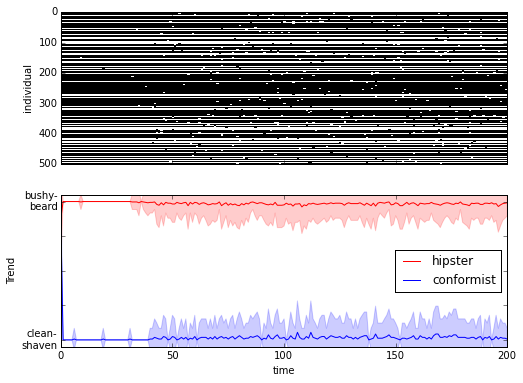

In [8]:
from IPython.html.widgets import interact, fixed

interact(plot_results, hipster_frac=(0.0, 1.0), delay=(1, 50),
         initial_state_frac=(0.0, 1.0), log10_beta=(-2.0, 2.0),
         Npeople=fixed(500), Nsteps=fixed(200), rseed=fixed(42));

Again, unless you [download the notebook](http://jakevdp.github.io/downloads/notebooks/HipsterEffect.ipynb) and run it on a local Python kernel, all you'll see is a static graphic above. But with the interactive version, you can really start to see how these various parameters affect the system.

## Conclusion

This has been a lot of fun, and if you've read this far I hope this helped you understand the mathematics of Hipster-dom! For more information and analysis, go [read the paper](http://arxiv.org/abs/1410.8001). It goes much deeper than the rough, discrete approximation I've used here.

For further ideas, I'd love to see a simulation of how this looks if we add-in spatial information, and create a delay related to that information. Would you start to see pockets of people adapting similar styles? My guess is yes, but I'm not entirely sure... there's only one way to find out.

Happy coding!

<small>
This post was written entirely in the IPython notebook.  You can
[download](http://jakevdp.github.io/downloads/notebooks/HipsterEffect.ipynb)
this notebook, or see a static view
[here](http://nbviewer.ipython.org/url/jakevdp.github.io/downloads/notebooks/HipsterEffect.ipynb).
</small>